### 1. Импорт библиотек

In [1799]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import urllib.request
import warnings
import zipfile

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [1800]:
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib').setLevel(logging.ERROR)

### 2. Создание каталога и скачивание данных

In [1801]:
if not os.path.exists('data/raw'):
  os.makedirs('data/raw')

if not os.path.exists('data/raw/urfusf2024reg.zip'):
  urllib.request.urlretrieve('https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/70601/7722061/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1738309138&Signature=gfT8vFuLeUEHi2e5Y8biU8MgmluVAo7CyDM5W2TOOTphiJAVL9s1YLtagNXWv2nVQSsP26cB50kfUz3C0WJlY%2FCkYyRkn6UEh9reGBXynecGgOEXPwvxtY2RBeFP6cxExYiFE7%2BXgkIpYfs2ma7tPBeXMO3wtty8GTvd9X23r3W8X4AOmWT5p%2B6tVvxwUnXpmJuOWtcE%2F2Pv6lHA6whBPm2ZcIX30Mb8e0PLH6NicX5keh9FFjl1i5cVtinoI8Pbd%2F0STVAgvVFSP1cEVVe4%2BVI%2F0ejGR%2BcFZobOl7IPYJKyqjrH41fLzWucpv9iTSrw%2FOYfS1pDFcOi86%2FAvaxvuw%3D%3D&response-content-disposition=attachment%3B+filename%3Durfusf2024reg.zip', 'data/raw/urfusf2024reg.zip')

with zipfile.ZipFile('data/raw/urfusf2024reg.zip') as f:
  f.extractall('data/raw')

### 3. Загрузка набора данных из файла

In [1802]:
assessments_df = pd.read_csv('data/raw/assessments.csv')
courses_df = pd.read_csv('data/raw/courses.csv')
vle_df = pd.read_csv('data/raw/vle.csv')

student_assessments_df = pd.read_csv('data/raw/studentAssessment.csv')
student_info_df = pd.read_csv('data/raw/studentInfo.csv')
student_registrations_df = pd.read_csv('data/raw/studentRegistration.csv')
student_vle_df = pd.read_csv('data/raw/studentVle.csv')

In [1803]:
submission_registrations_df = pd.read_csv('data/raw/Submission_reg.csv', index_col='ID')
target_train_df = pd.read_csv('data/raw/Train_Target_reg.csv', index_col='ID')
who_test_df = pd.read_csv('data/raw/Test_Who.csv')
who_train_df = pd.read_csv('data/raw/Train_Who.csv')

### 4. Определение функций

In [1804]:
def findDiffValues(df1, df2, col):
  '''
  Найти все значения df1.col, отсутствующие в df2.col
  '''
  # Вытащите все уникальные значения col
  df1_IDs = df1[col].unique()
  df2_IDs = df2[col].unique()

  # Сравните два списка
  # (a) Найдите, какие значения отличаются
  diff = set(df1_IDs).difference(set(df2_IDs))
  # (b) осчитайте, сколько разных
  numberDiff = len(diff)

  print("Значения из df1 не в df2: " + str(diff))
  print("Количество пропущенных значений: " + str(numberDiff))

In [1805]:
def cramers_v(x, y):
  confusion_matrix = pd.crosstab(x, y)
  chi2 = ss.chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2 / n
  r, k = confusion_matrix.shape
  phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
  rcorr = r - ((r - 1) ** 2) / (n - 1)
  kcorr = k - ((k - 1) ** 2) / (n - 1)
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [1806]:
def cramers_col(X, columns, column_name):
  col = pd.Series(np.empty(X[columns].columns.shape), index=X[columns].columns, name=column_name)
  for row in X[columns]:
    cram = cramers_v(X[columns][column_name], X[columns][row])
    col[row] = round(cram, 2)
  return col

### 5. Обьединение таблиц

#### 5.1. Объединение таблиц об оценках студентов и результатами оценок

In [1807]:
student_assessments_merged_df = pd.merge(student_assessments_df, assessments_df, on='id_assessment', how='inner')
student_assessments_merged_df.head()

,id_assessment,id_student,date_submitted,is_banked,code_module,code_presentation,assessment_type,date,weight
0,1752,11391,18,0,AAA,2013J,TMA,19.0,10.0
1,1752,28400,22,0,AAA,2013J,TMA,19.0,10.0
2,1752,31604,17,0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,AAA,2013J,TMA,19.0,10.0
4,1752,38053,19,0,AAA,2013J,TMA,19.0,10.0


#### 5.2. Групиовка оценок и заполнение медианым значением

In [1808]:
student_assessments_merged_df = student_assessments_merged_df \
  .groupby(["id_student"],) \
  .agg(date_submitted=pd.NamedAgg(column='date_submitted', aggfunc='median'), date=pd.NamedAgg(column="date", aggfunc="median")) \
  .reset_index()

student_assessments_merged_df.head()

,id_student,date_submitted,date
0,6516,116.0,117.0
1,8462,-1.0,53.0
2,11391,115.0,117.0
3,23629,59.5,50.5
4,23698,147.0,126.5


#### 5.3. Объединение таблиц о регистрациях студентов и информации о студентах

In [1809]:
student_regs_info_merged_df = pd.merge(student_registrations_df, student_info_df, on=["id_student", "code_module", "code_presentation"])
student_regs_info_merged_df.head()

,code_module,code_presentation,id_student,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,-159.0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,-53.0,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,AAA,2013J,30268,-92.0,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,AAA,2013J,31604,-52.0,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,AAA,2013J,32885,-176.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N


In [1810]:
findDiffValues(who_train_df, student_regs_info_merged_df, "id_student")

Значения из df1 не в df2: set()
Количество пропущенных значений: 0


#### 5.4. Добавление к объединенной таблице с данными о студентах таблицы с данными о курсах

In [1811]:
student_regs_info_courses_merged_df = pd.merge(student_regs_info_merged_df, courses_df, on=['code_module', 'code_presentation'], how='inner')
student_regs_info_courses_merged_df.head()

,code_module,code_presentation,id_student,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length
0,AAA,2013J,11391,-159.0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,268
1,AAA,2013J,28400,-53.0,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,268
2,AAA,2013J,30268,-92.0,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,268
3,AAA,2013J,31604,-52.0,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,268
4,AAA,2013J,32885,-176.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,268


In [1812]:
findDiffValues(who_train_df, student_regs_info_courses_merged_df, "id_student")

Значения из df1 не в df2: set()
Количество пропущенных значений: 0


#### 5.5. Добавление к объединенной таблице с данными о студентах таблицы с данными о взаимодействии с VLE

In [1813]:
vle_aggregated_df = student_vle_df \
  .groupby(['id_student', 'code_module', 'code_presentation']) \
  .agg(total_clicks=pd.NamedAgg(column='sum_click', aggfunc='sum')) \
  .reset_index()

student_regs_info_courses_vle_merged_df = pd.merge(student_regs_info_courses_merged_df, vle_aggregated_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
student_regs_info_courses_vle_merged_df.head()

,code_module,code_presentation,id_student,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length,total_clicks
0,AAA,2013J,11391,-159.0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,268,934.0
1,AAA,2013J,28400,-53.0,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,268,1435.0
2,AAA,2013J,30268,-92.0,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,268,281.0
3,AAA,2013J,31604,-52.0,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,268,2158.0
4,AAA,2013J,32885,-176.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,268,1034.0


#### 5.6. Добавление к объединенной таблице с данными о студентах таблицы с данными об оценках

In [1814]:
students_df = pd.merge(student_regs_info_courses_vle_merged_df, student_assessments_merged_df, on=['id_student'], how="left")
students_df.head()

,code_module,code_presentation,id_student,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length,total_clicks,date_submitted,date
0,AAA,2013J,11391,-159.0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,268,934.0,115.0,117.0
1,AAA,2013J,28400,-53.0,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,268,1435.0,121.0,117.0
2,AAA,2013J,30268,-92.0,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,268,281.0,NaN,NaN
3,AAA,2013J,31604,-52.0,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,268,2158.0,115.0,117.0
4,AAA,2013J,32885,-176.0,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,268,1034.0,124.0,117.0


In [1815]:
findDiffValues(who_train_df, students_df, "id_student")

Значения из df1 не в df2: set()
Количество пропущенных значений: 0


### 6. Предварительный аналих и обработка данных

#### 6.1. Вывод информации о пропущенных значениях

In [1816]:
students_df.isna().sum()

code_module                      0
code_presentation                0
id_student                       0
date_registration               45
gender                           0
region                           0
highest_education                0
imd_band                      1111
age_band                         0
num_of_prev_attempts             0
studied_credits                  0
disability                       0
module_presentation_length       0
total_clicks                  3365
date_submitted                5847
date                          5847
dtype: int64

#### 6.2. Удаление строк с пропущенными значениями в поле "date_registration"

In [1817]:
students_df = students_df.dropna(subset=['date_registration'])

#### 6.3. Замена пропущенных значений в столбце "total_clicks" медианным значением

In [1818]:
median_clicks = students_df['total_clicks'].median()
students_df['total_clicks'] = students_df['total_clicks'].fillna(median_clicks)

print(f'Медианное значение: | {median_clicks}')

Медианное значение: | 740.0


#### 6.3. Замена пропущенных значений в столбце "imd_band" значением "other"

In [1819]:
students_df['imd_band'] = students_df['imd_band'].fillna('other')

#### 6.4. Замена пропущенных значений в столбцах "date" и "date_submitted"

 ##### 6.4.1. Построение гистограмы

Text(0, 0.5, 'Количество студентов')

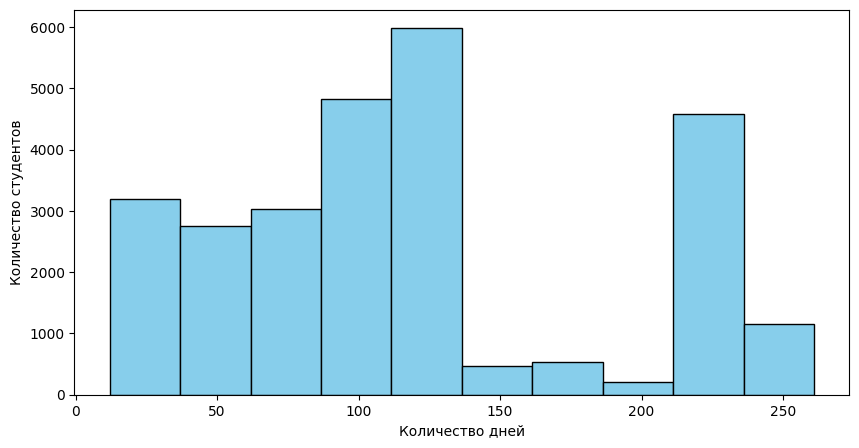

In [1820]:
plt.figure(figsize=(10, 5))
plt.hist(students_df['date'], color='skyblue', edgecolor='black')
# plt.title('Количество студентов в зависимости от даты начала презентации модуля')
plt.xlabel('Количество дней')
plt.ylabel('Количество студентов')

На гистограмме выделяются два пика около 120 и 230. Соответственно, для заполнения прпопусков целесообразнее взять медианное значение.

##### 6.4.2. Замена пропущенных значений в столбце "date" медианным значением

In [1821]:
median_date = students_df['date'].median()
students_df['date'] = students_df['date'].fillna(median_date)

print(f'Медианное значение: | {median_date}')

Медианное значение: | 110.0


##### 6.4.3. Замена пропущенных значений в столбце "date_submitted" медианным значением

In [1822]:
median_date_submitted = students_df['date_submitted'].median()
students_df['date_submitted'] = students_df['date_submitted'].fillna(median_date_submitted)

print(f'Медианное значение: | {median_date_submitted}')

Медианное значение: | 109.0


#### 6.5. Вывод информации о пропущенных значениях

In [1823]:
students_df.isnull().sum()

code_module                   0
code_presentation             0
id_student                    0
date_registration             0
gender                        0
region                        0
highest_education             0
imd_band                      0
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
module_presentation_length    0
total_clicks                  0
date_submitted                0
date                          0
dtype: int64

#### 6.6. Приведение поля "id_student" к типу "object"

In [1824]:
students_df['id_student'] = students_df['id_student'].astype(object)

#### 6.7. Создание тренировочного набора данных

In [1825]:
students_train_df = pd.merge(who_train_df, students_df, on=['id_student', 'code_module', 'code_presentation'], how='left')
students_train_df = pd.merge(students_train_df, target_train_df, on='ID')

students_train_df.index = students_train_df.ID
students_train_df = students_train_df.drop(columns = ['ID'])
students_train_df.head()

,id_student,code_module,code_presentation,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length,total_clicks,date_submitted,date,weighted_score
ID,,,,,,,,,,,,,,,,,
0,464685,DDD,2014B,-36.0,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1.0,70.0,N,241.0,1694.0,122.0,116.0,64.9125
1,606593,DDD,2013J,-32.0,M,Scotland,A Level or Equivalent,20-30%,0-35,0.0,120.0,N,261.0,692.0,53.0,53.0,14.8625
2,1674799,CCC,2014J,-21.0,M,South Region,HE Qualification,70-80%,55<=,0.0,60.0,N,269.0,1963.0,149.5,131.0,61.4300
3,195246,FFF,2014J,-124.0,M,West Midlands Region,Lower Than A Level,10-20,0-35,0.0,60.0,N,269.0,2138.0,110.0,241.0,39.5000
4,582080,FFF,2013J,-114.0,M,South East Region,Lower Than A Level,10-20,35-55,0.0,60.0,N,268.0,188.0,19.0,19.0,9.2500


#### 6.7. Создание тестового набора данных

In [1826]:
students_test_df = pd.merge(who_test_df, students_df, on=['id_student', 'code_module', 'code_presentation'], how='left')

students_test_df.index = students_test_df.ID
students_test_df = students_test_df.drop(columns = ['ID'])
students_test_df.head()

,id_student,code_module,code_presentation,date_registration,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,module_presentation_length,total_clicks,date_submitted,date
ID,,,,,,,,,,,,,,,,
26074,2588655,DDD,2014J,-92.0,M,Scotland,Lower Than A Level,50-60%,0-35,2.0,60.0,N,262.0,297.0,53.0,57.5
26075,543628,CCC,2014B,-109.0,M,North Western Region,HE Qualification,0-10%,35-55,0.0,90.0,N,241.0,740.0,109.0,110.0
26076,387276,BBB,2013B,-88.0,F,North Western Region,Lower Than A Level,50-60%,35-55,1.0,180.0,N,240.0,740.0,109.0,110.0
26077,692219,CCC,2014J,-34.0,M,South Region,A Level or Equivalent,20-30%,0-35,0.0,90.0,N,269.0,283.0,21.0,18.0
26078,516212,BBB,2013J,-134.0,F,East Midlands Region,A Level or Equivalent,20-30%,0-35,0.0,60.0,N,268.0,740.0,109.0,110.0


#### 6.8. Формирование списков числовых и категориальных признаков

In [1827]:
categorical_columns = []
numeric_columns = []

for column_name in students_df.columns:
  if (students_df[column_name].dtypes == object):
    categorical_columns += [column_name]
  else:
    numeric_columns += [column_name]

print('Категориальные признаки: ')
print('\n'.join(categorical_columns))

print('--------------------------')

print('Числовые признаки: ')
print('\n'.join(numeric_columns))

Категориальные признаки: 
code_module
code_presentation
id_student
gender
region
highest_education
imd_band
age_band
disability
--------------------------
Числовые признаки: 
date_registration
num_of_prev_attempts
studied_credits
module_presentation_length
total_clicks
date_submitted
date


#### 6.10. Создание наборов даннных из признаков и целевой переменной

In [1828]:
X_train_df, y_train_df = students_train_df.drop(['weighted_score'], axis=1), students_train_df['weighted_score']
X_test_df = students_test_df

#### 6.11. Расчет коэффициента корреляции Пирсона для числовых признаков

In [1829]:
corr_pirson = students_train_df [numeric_columns].corrwith(y_train_df)
corr_pirson

date_registration             0.000976
num_of_prev_attempts         -0.095955
studied_credits              -0.090137
module_presentation_length    0.050656
total_clicks                  0.390004
date_submitted                0.572950
date                          0.519881
dtype: float64

#### 6.12. Рассчет V-коэффициента корреляции Крамера для измерения связи между категориальными признаками

In [1830]:
for column in categorical_columns:
  corr_cramers = cramers_v(X_train_df[column], y_train_df)
  print(f'{column}: {round(corr_cramers, 3)}')

code_module: 0.452
code_presentation: 0.219
id_student: 0.0
gender: 0.293
region: 0.06
highest_education: 0.19
imd_band: 0.08
age_band: 0.15
disability: 0.0


По результатам вычисления оэффициентов корреляции Пирсона и V-коэффициента корреляции Крамера оставим без изменений числовые признаки и удалим категориальные признаки ```id_student``` и ```disability```.

#### 6.13. Удаление признаков "id_student" и "disability" 

In [1831]:
X_train_df = X_train_df.drop(['id_student','disability',], axis=1)
X_test_df = X_test_df.drop(['id_student','disability',], axis=1)

In [1832]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26074 entries, 0 to 26073
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 26074 non-null  object 
 1   code_presentation           26074 non-null  object 
 2   date_registration           26037 non-null  float64
 3   gender                      26037 non-null  object 
 4   region                      26037 non-null  object 
 5   highest_education           26037 non-null  object 
 6   imd_band                    26037 non-null  object 
 7   age_band                    26037 non-null  object 
 8   num_of_prev_attempts        26037 non-null  float64
 9   studied_credits             26037 non-null  float64
 10  module_presentation_length  26037 non-null  float64
 11  total_clicks                26037 non-null  float64
 12  date_submitted              26037 non-null  float64
 13  date                        26037 no

In [1833]:
X_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6519 entries, 26074 to 32592
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 6519 non-null   object 
 1   code_presentation           6519 non-null   object 
 2   date_registration           6511 non-null   float64
 3   gender                      6511 non-null   object 
 4   region                      6511 non-null   object 
 5   highest_education           6511 non-null   object 
 6   imd_band                    6511 non-null   object 
 7   age_band                    6511 non-null   object 
 8   num_of_prev_attempts        6511 non-null   float64
 9   studied_credits             6511 non-null   float64
 10  module_presentation_length  6511 non-null   float64
 11  total_clicks                6511 non-null   float64
 12  date_submitted              6511 non-null   float64
 13  date                        6511 

### 7. Создание пайплайна

#### 7.1. Опредение классов обработчиков данных 

In [1834]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
  def __init__(self, threshold=0.05):
    self.threshold = threshold
    self.quantiles = {}

  def fit(self, X, y=None):
    for col in X.select_dtypes(include='number'):
      low_quantile = X[col].quantile(self.threshold)
      high_quantile = X[col].quantile(1 - self.threshold)
      self.quantiles[col] = (low_quantile, high_quantile)
    return self

  def transform(self, X):
    X_copy = X.copy()
    for col in X.select_dtypes(include='number'):
      low_quantile, high_quantile = self.quantiles[col]
      rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
      if rare_mask.any():
        rare_values = X_copy.loc[rare_mask, col]
        replace_value = np.mean([low_quantile, high_quantile])
        if rare_values.mean() > replace_value:
          X_copy.loc[rare_mask, col] = high_quantile
        else:
          X_copy.loc[rare_mask, col] = low_quantile
    return X_copy

In [1835]:
class RareGrouper(BaseEstimator, TransformerMixin):
  def __init__(self, threshold=0.05, other_value='Other'):
    self.threshold = threshold
    self.other_value = other_value
    self.freq_dict = {}

  def fit(self, X, y=None):
    for col in X.select_dtypes(include=['object']):
      freq = X[col].value_counts(normalize=True)
      self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
    return self

  def transform(self, X, y=None):
    X_copy = X.copy()
    for col in X.select_dtypes(include=['object']):
      X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
    return X_copy

In [1836]:
class TargetEncoder(BaseEstimator, TransformerMixin):
  def __init__(self, cols=None):
    self.cols = cols
    self.target_mean = {}

  def fit(self, X, y):
    if self.cols is None:
      self.cols = X.columns
    for col in self.cols:
      self.target_mean[col] = {}
      X_copy = X.copy()
      X_copy[y.name]=y
      self.target_mean[col] = X_copy.groupby(col)[y.name].mean().to_dict()
    return self

  def transform(self, X):
    for col in self.cols:
      X[col] = X[col].map(self.target_mean[col])
      X[col] = X[col].fillna(np.mean(X[col]))
    return X

#### 7.2. Определение обрабочиков для числовых и категориальных признаков

In [1837]:
categorical_pipe_gender = Pipeline([
  ('rare', RareGrouper(threshold=0.001, other_value='Other')),
  ('encoder', TargetEncoder())
])

categorical_gender = ['gender']

categorical_pipe_code_module = Pipeline([
  ('rare', RareGrouper(threshold=0.001, other_value='Other')),
  ('encoder', TargetEncoder())
])

categorical_code_module = ['code_module']

categorical_pipe_code_presentation = Pipeline([
  ('rare', RareGrouper(threshold=0.001, other_value='Other')),
  ('encoder', TargetEncoder())
])

categorical_code_presentation = ['code_presentation']

categorical_pipe_region = Pipeline([
  ('rare', RareGrouper(threshold=0.001, other_value='Other')),
  ('encoder', TargetEncoder())
])

categorical_region = ['region']

categorical_pipe_highest_education = Pipeline([
  ('rare', RareGrouper(threshold=0.001, other_value='Other')),
  ('encoder', TargetEncoder())
])

categorical_highest_education = ['highest_education']

categorical_pipe_imd_band = Pipeline([
  ('rare', RareGrouper(threshold=0.001, other_value='Other')),
  ('encoder', TargetEncoder())
])

categorical_imd_band = ['imd_band']

categorical_pipe_age_band = Pipeline([
  ('rare', RareGrouper(threshold=0.001, other_value='Other')),
  ('encoder', TargetEncoder())
])

categorical_age_band = ['age_band']

numeric_pipe_date_submitted = Pipeline([
  ('QuantReplace', QuantileReplacer(threshold=0.01)),
  ('scaler', None)
])

numeric_date_submitted = ['date_submitted']

numeric_pipe_module_presentation_length = Pipeline([
  ('QuantReplace', QuantileReplacer(threshold=0.01)),
  ('scaler', None)
])

numeric_module_presentation_length = ['module_presentation_length']

numeric_pipe_total_clicks = Pipeline([
  ('QuantReplace', QuantileReplacer(threshold=0.01)),
  ('scaler', None)
])

numeric_total_clicks = ['total_clicks']

numeric_pipe_studied_credits = Pipeline([
  ('QuantReplace', QuantileReplacer(threshold=0.01)),
  ('scaler', None)
])

numeric_studied_credits = ['studied_credits']

numeric_pipe_date = Pipeline([
  ('QuantReplace', QuantileReplacer(threshold=0.01)),
  ('scaler', None)
])

numeric_date = ['date']

numeric_pipe_date_registration = Pipeline([
  ('QuantReplace', QuantileReplacer(threshold=0.01)),
  ('scaler', None)
])

numeric_date_registration = ['date_registration']

numeric_pipe_num_of_prev_attempts = Pipeline([
  ('QuantReplace', QuantileReplacer(threshold=0.01)),
  ('scaler', None)
])

numeric_of_prev_attempts = ['num_of_prev_attempts']

#### 7.3. Создание обработчика даннных числовых признаков

In [1838]:
preprocessors_numeric = ColumnTransformer(transformers=[
  ('numeric_date_registration', numeric_pipe_date_registration, numeric_date_registration),
  ('numeric_date_submitted', numeric_pipe_date_submitted, numeric_date_submitted),
  ('numeric_date', numeric_pipe_date, numeric_date),
  ('numeric_module_presentation_length', numeric_pipe_module_presentation_length, numeric_module_presentation_length),
  ('numeric_of_prev_attempts', numeric_pipe_num_of_prev_attempts, numeric_of_prev_attempts),
  ('numeric_studied_credits', numeric_pipe_studied_credits, numeric_studied_credits),
  ('numeric_total_clicks', numeric_pipe_total_clicks, numeric_total_clicks)
])

#### 7.3. Создание обработчика даннных числовых и категориальных признаков

In [1839]:
preprocessors_all = ColumnTransformer(transformers=[
  ('categorical_age_band', categorical_pipe_age_band, categorical_age_band),
  ('categorical_code_module', categorical_pipe_code_module, categorical_code_module),
  ('categorical_code_presentation', categorical_pipe_code_presentation, categorical_code_presentation),
  ('categorical_gender', categorical_pipe_gender, categorical_gender),
  ('categorical_highest_education', categorical_pipe_highest_education, categorical_highest_education),
  ('categorical_imd_band', categorical_pipe_imd_band, categorical_imd_band),
  ('categorical_region', categorical_pipe_region, categorical_region),
  ('numeric_date_registration', numeric_pipe_date_registration, numeric_date_registration),
  ('numeric_date_submitted', numeric_pipe_date_submitted, numeric_date_submitted),
  ('numeric_date', numeric_pipe_date, numeric_date),
  ('numeric_module_presentation_length', numeric_pipe_module_presentation_length, numeric_module_presentation_length),
  ('numeric_of_prev_attempts', numeric_pipe_num_of_prev_attempts,numeric_of_prev_attempts),
  ('numeric_studied_credits', numeric_pipe_studied_credits, numeric_studied_credits),
  ('numeric_total_clicks', numeric_pipe_total_clicks, numeric_total_clicks)
])

#### 7.4. Преобразование числовых данных тренировочной и тестовой выборок

In [1840]:
X_train = preprocessors_numeric.fit_transform(X_train_df)
X_test = preprocessors_numeric.transform(X_test_df)

y_train = y_train_df

#### 7.5. Создание модели и поиск наилучших гиперпараметров модели

In [1841]:
model_rf = RandomForestRegressor(random_state=42)

param_grid = {
  'n_estimators': [100, 300, 500],
  'max_depth': [10, 50, 100],
  'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
  estimator=model_rf,
  param_grid=param_grid,
  cv=5,
  scoring='neg_mean_squared_error',
  n_jobs=-1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 50, 100],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_mean_squared_error')

#### 7.6. Вывод наилучших гиперпараметров модели

In [1842]:
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}


#### 7.7. Вывод наилучшей метрики MSE

In [1843]:
# Вывод лучшего значения MSE (необходимо взять абсолютное значение, так как скоринг был отрицательным)
print("Лучшее значение MSE:", abs(grid_search.best_score_))

Лучшее значение MSE: 361.95814561897


#### 7.8. Создание модели "RandomForestRegressor"

In [1844]:
model_rf = RandomForestRegressor(
  random_state=42,
  n_estimators=1000,
  max_depth=20,
  min_samples_split=20
)

#### 7.9. Обучение модели "RandomForestRegressor"

In [1845]:
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=20, n_estimators=1000,
                      random_state=42)

#### 7.10. Предсказание результата на тестовых данных

In [1846]:
predict = model_rf.predict(X_test)

#### 7.11. Создание пайплайна для преобразования данных и ообучения модели

In [1847]:
pipe_all = Pipeline([
  ('preprocessors', preprocessors_all),
  ('model', model_rf)
])

#### 7.12. Обучение модели

In [1848]:
pipe_all.fit(X_train_df, y_train_df)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('categorical_age_band',
                                                  Pipeline(steps=[('rare',
                                                                   RareGrouper(threshold=0.001)),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  ['age_band']),
                                                 ('categorical_code_module',
                                                  Pipeline(steps=[('rare',
                                                                   RareGrouper(threshold=0.001)),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  ['code_module']),
                                                 ('categorical_code_presentation',
                                                  Pi...
                                                 ('numeric_studied_credits',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   None)]),
                                                  ['studied_credits']),
                                                 ('numeric_total_clicks',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   None)]),
                                                  ['total_clicks'])])),
                ('model',
                 RandomForestRegressor(max_depth=20, min_samples_split=20,
                                       n_estimators=1000, random_state=42))])

#### 7.13. Предсказание результата на тренировочных данных

In [1849]:
predicted_values = pipe_all.predict(X_train_df)

print(f'Метрика MSE на тренировочных данных: | {mse(y_train, predicted_values)}')

Метрика MSE на тренировочных данных: | 204.63128984180182


#### 7.14. Предсказание результата на тестовых данных

In [1850]:
predicted_values = pipe_all.predict(X_test_df)

In [1851]:
submission_registrations_df['weighted_score'] = predicted_values
submission_registrations_df.to_csv('data/submission.csv', index=True)

![leaderboard.png](images/leaderboard.png)